<a href="https://colab.research.google.com/github/sourcecode369/deep-natural-language-processing/blob/master/sentiment%20analysis/Sentiment_Analysis_on_Hotel_Reviews_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np 
import os
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import re
import collections 

%tensorflow_version 2.x
import tensorflow as tf
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers

TensorFlow 2.x selected.


In [0]:
NB_WORDS = 10000
VAL_SIZE = 1000
NB_START_EPOCHS = 20
BATCH_SIZE = 512

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rhtsingh","key":"dcd184742d2df1ff3dbfb96833c0c0f1"}'}

In [0]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d crowdflower/twitter-airline-sentiment

  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 171MB/s]


In [6]:
import zipfile
with zipfile.ZipFile('twitter-airline-sentiment.zip','r') as zf:
  zf.extractall()
print('Done.!')

Done.!


In [7]:
df = pd.read_csv('Tweets.csv')
df = df.reindex(np.random.permutation(df.index))
df = df[['text','airline_sentiment']]
df.head()

,text,airline_sentiment
11127,"@USAirways Only for one flight, though. The 2n...",neutral
10188,@USAirways Our flight was Cancelled Flightled ...,negative
6828,@JetBlue can't link my flight from last week t...,negative
891,@united awesome I'll book my next Christmas va...,positive
4074,@united IT-problems with the link? #3thparty,negative


In [8]:
import wordcloud

def remove_stopwords(input_text):
  stopwords_list = set(wordcloud.STOPWORDS)
  whitelist = ["n't","not","no"]
  words = input_text.split()
  clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word)>1]
  return " ".join(clean_words)

def remove_mentions(input_text):
  return re.sub(r'@\w+', '', input_text)

df.text = df.text.apply(remove_stopwords).apply(remove_mentions)

from IPython.display import display 
from tqdm import tqdm, tqdm_notebook
with pd.option_context("display.max_rows",10,"display.max_columns",100):
  display(df)

,text,airline_sentiment
11127,"Only one flight, though. The 2nd leg kids sit...",neutral
10188,Our flight Cancelled Flightled &amp; chaos ab...,negative
6828,link flight last week TruBlue account 1800 nu...,negative
891,awesome I'll book next Christmas vacatinn Dec...,positive
4074,IT-problems link? #3thparty,negative
...,...,...
4429,booked flight phone never got confirmation em...,negative
3033,point offering free checked bag lose it?,negative
6703,kudos #RSW CS crew re-routing PAX alleviate O...,negative
5867,"ok, gotcha! ✈️😃👍",positive


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=2020)

In [0]:
tk = Tokenizer(NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ")
tk.fit_on_texts(X_train)

In [11]:
print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 13176 documents
10000 words in dictionary
Top 5 most common words are: [('flight', 3550), ('not', 1426), ('no', 1326), ('t', 1098), ('co', 1094)]


In [0]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [0]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1
    return ohs
X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

In [0]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [0]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=2020)

### Simple Deep Neural Network

In [61]:
model = models.Sequential()
model.add(layers.Dense(2048, activation='relu', input_shape=(NB_WORDS,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 2048)              20482048  
_________________________________________________________________
dropout_8 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 3075      
Total params: 22,583,299
Trainable params: 22,583,299
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
from tensorflow.keras.callbacks import *
from IPython.display import clear_output, display

In [0]:
class PlotLearning(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []
    self.loss = []
    self.val_loss = []
    self.acc = []
    self.val_acc = []
    self.fig = plt.figure()
    self.logs = []

  def on_epoch_end(self, epoch, logs={}): 
    self.logs.append(logs)
    self.x.append(self.i)
    self.loss.append(logs.get('loss'))
    self.acc.append(logs.get('accuracy'))
    self.val_loss.append(logs.get('val_loss'))        
    self.val_acc.append(logs.get('val_accuracy'))
    self.i += 1
    f, ax = plt.subplots(1, 2, figsize=(18,10), sharex=True)
    ax = ax.flatten()
    clear_output(wait=True)
    ax[0].plot(self.x, self.loss, label="Binary Cross Entropy", lw=2)
    ax[0].plot(self.x, self.val_loss, label="Val Binary Cross Entropy")
    ax[0].legend()
    ax[0].grid(True)
    ax[1].plot(self.x, self.acc, label="Accuracy", lw=2)
    ax[1].plot(self.x, self.val_acc, label="Val Accuracy")
    ax[1].legend()
    ax[1].grid(True)
    plt.show();

reduce_lr = ReduceLROnPlateau(monitor="val_loss",factor=0.3,patience=3,verbose=1,mode="auto",min_lr=0.000001)
checkpoint = ModelCheckpoint("base_clf.h5",monitor="val_loss",verbose=1,save_best_only=True,mode="auto")
early_stopping = EarlyStopping(monitor="val_loss",patience=6,mode="auto")
plotLoss = PlotLearning()



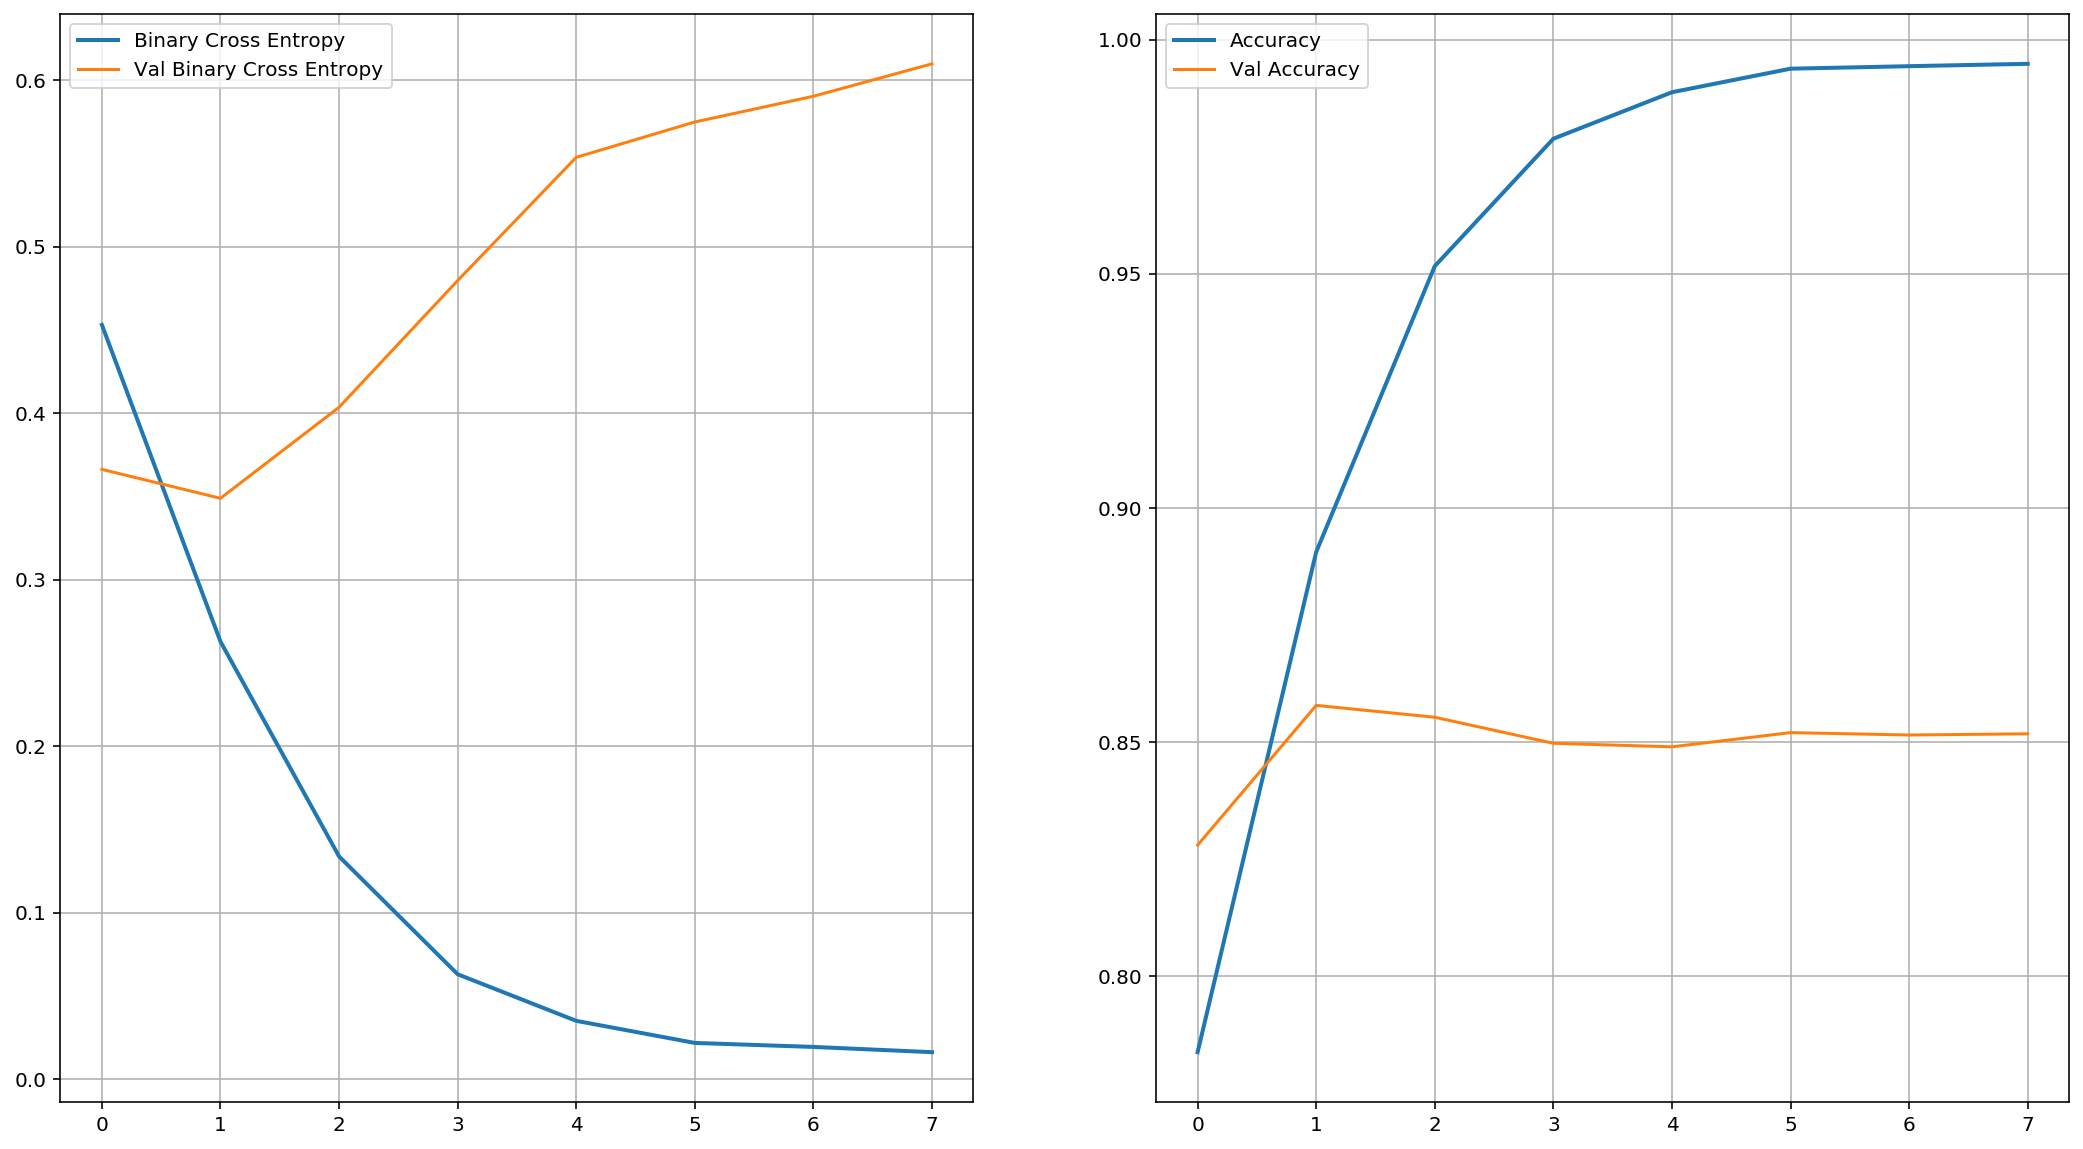

11858/11858 - 2s - loss: 0.0163 - accuracy: 0.9949 - val_loss: 0.6100 - val_accuracy: 0.8518


In [65]:
history = model.fit(X_train_rest
                       , y_train_rest
                       , epochs=30
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=2
                    , callbacks=[reduce_lr, checkpoint, early_stopping, plotLoss])

In [66]:
model.evaluate(X_valid, y_valid)

1318/1318 [==============================] - 0s 103us/sample - loss: 0.6100 - accuracy: 0.8518


[0.610004671607647, 0.8517956]

In [0]:
preds = np.argmax(model.predict(X_test_oh),axis=1)

In [0]:
y_test_oh = np.argmax(y_test_oh,axis=1)

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(preds, y_test_oh)

In [0]:
import seaborn as sns

Accuracy: 78.89%


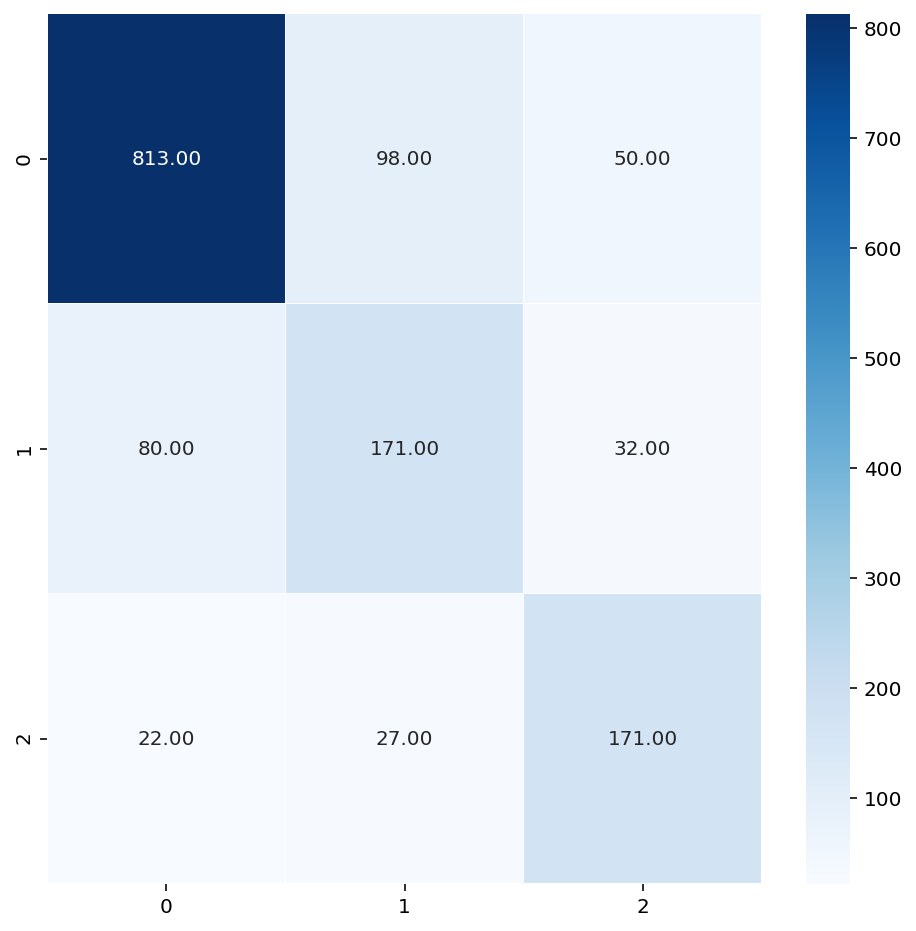

In [90]:
plt.figure(figsize=(8,8))
sns.heatmap(cm,annot=True,fmt='.2f', cmap='Blues',linewidth=0.1)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test_oh, preds)*100))

### Word2Vec